In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import geopandas as gpd
import swifter
from shapely import wkt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statsmodels.api as sm
style.use(style='fivethirtyeight')
%matplotlib inline

## Intro
The COVID pandemic has been an event unlike anything faced in recent history. For a year much of the world came to a crawl as people theorized when we might be able to return to "normal". Finally, as vaccines became available it seemed like that might actually be a reality. However, a new, somewhat unforeseen, challenge soon emerged: getting the necessary amount of people to get fully vaccinated to reach herd immunity. So why, and where, are we having so much trouble getting the vaccine rolled out in the United States? Who is hesitent to get vaccinated? In this project we will look at the demographics of counties all across the country along with vaccine hesitency and political voting data to try and answer these questions. <br><br>

<b>Data Overview</b><br>
The core of our data comes from the CDC and their 'Vaccine Hesitancy for COVID-19: County and local estimates' dataset. It can be found [here](https://data.cdc.gov/Vaccinations/Vaccine-Hesitancy-for-COVID-19-County-and-local-es/q9mh-h2tw) on the CDC website.  It includes a number of useful data points on each county in the United States to which we will be adding county population data from the [US Census](https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html) and county presidential voting record data from the 2016 election curtesy of the MIT Election Lab that can be found [here](https://electionlab.mit.edu/data). Texas reports their vaccination data seperately on the Texas Health and Human Services website which can be found [here](https://www.dshs.texas.gov/coronavirus/immunize/vaccine.aspx)<br><br>

<b>CDC Data</b><br>
The CDC Vaccine Hesitency dataset contains 21 columns, most of which are very helpful and I will explain here briefly. Descriptions of all 21 columns can be found at the link provided int he previous paragraph for the dataset.<br>
<b>FIPS Code: </b>A unique code for each county <br>
<b>County Name: </b>The name of the county, including state name <br>
<b>Estimated hesitant: </b>'Estimate of percentage of adults who describe themselves as “probably not” or “definitely not” going to get a COVID-19 vaccine once one is available to them, based on national survey data.' <br>
<b>Estimated hesitant or unsure: </b>'Estimate of percentage of adults who describe themselves as “unsure”, “probably not”, or “definitely not” going to get a COVID-19 vaccine once one is available to them, based on national survey data.' <br>
<b>Estimated strongly hesitant: </b>'Estimate of percentage of adults who describe themselves as “definitely not” going to get a COVID-19 vaccine once one is available to them, based on national survey data.' <br>
<b>Social Vulnerability Index (SVI): </b>An index calcuated from 15 census variables to identify communities that may need support before, during, or after a disaster, including a disease outbreak. <br>
<b>Percent adults fully vaccinated against COVID-19: </b>The percent of full vaccinated adults in the county. This includes both shots for the Pfizer and Moderna vaccines and one shot for the Johnson & Johnson. <br>
<b>There are six columns, one for each of the percent of: Hispanic, non-Hispanic Black, Asian, American Indian/Alaska Native, and White.</b><br>
<b>County Boundary: </b>A field that contains information regarding the shape of the county and it's location on a grid. <br><br>

<b>Getting Started</b><br>
We'll start by reading in the CDC data and cleaning the data for analysis by handling any outliers, null values, and converting it to a GeoDataFrame for visualizing the data as a map.

In [91]:
#Read in CDC dataset as dataframe
df_cdc = pd.read_csv('Vaccine_Hesitancy_for_COVID-19__County_and_local_estimates_523.csv')
df_cdc.head()

,FIPS Code,County Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,...,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,County Boundary,State Boundary
0,1079,"Lawrence County, Alabama",ALABAMA,0.1913,0.2762,0.0999,0.50,Moderate Vulnerability,0.80,High Concern,...,0.0219,0.0560,0.0020,0.1058,0.0008,0.7649,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.529795 34.518525, -87.5297...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
1,1107,"Pickens County, Alabama",ALABAMA,0.1825,0.2688,0.0917,0.92,Very High Vulnerability,0.78,High Concern,...,0.0487,0.0014,0.0006,0.3984,0.0006,0.5365,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-88.29705899999999 33.349083, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
2,1035,"Conecuh County, Alabama",ALABAMA,0.1915,0.2943,0.0963,0.81,Very High Vulnerability,0.89,Very High Concern,...,0.0068,0.0020,0.0045,0.4776,0.0000,0.5005,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.165662 31.542897, -87.1653...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."
3,4021,"Pinal County, Arizona",ARIZONA,0.1422,0.2077,0.0877,0.86,Very High Vulnerability,0.87,Very High Concern,...,0.3016,0.0430,0.0158,0.0408,0.0029,0.5679,POINT (-111.664616 34.293239),AZ,"MULTIPOLYGON (((-111.685911 33.204637, -111.61...",MULTIPOLYGON (((-114.516842 33.027885999999995...
4,1067,"Henry County, Alabama",ALABAMA,0.1929,0.2871,0.0996,0.55,Moderate Vulnerability,0.65,High Concern,...,0.0262,0.0018,0.0040,0.2655,0.0010,0.6917,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-85.415774 31.490413, -85.4153...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352..."


In [92]:
#Update county name column name
column_mapper_1 = {'County Name':'County_Name'}
df_cdc.rename(columns=column_mapper_1, inplace=True)

In [93]:
#Inspect data for nulls
df_cdc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   FIPS Code                                              3142 non-null   int64  
 1   County_Name                                            3142 non-null   object 
 2   State                                                  3142 non-null   object 
 3   Estimated hesitant                                     3142 non-null   float64
 4   Estimated hesitant or unsure                           3142 non-null   float64
 5   Estimated strongly hesitant                            3142 non-null   float64
 6   Social Vulnerability Index (SVI)                       3141 non-null   float64
 7   SVI Category                                           3141 non-null   object 
 8   CVAC level of concern for vaccination rollout   

## Cleaning the COVID County Info Data - Removing Outliers 
The columns I'm concerned about outliers in are the four non-census collected columns: Estimated hesitant or unsure, Estimated hesitant, Estimated strongly hesitant, and Percent adults fully vaccinated against COVID-19. We'll plot them each on box plots and decide if we want to drop any outliers. 

In [94]:
#Describe and inspect as we start the outlier removal process
df_cdc.describe()

,FIPS Code,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),CVAC level of concern for vaccination rollout,Percent adults fully vaccinated against COVID-19,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White
count,3142.000000,3142.000000,3142.000000,3142.000000,3141.000000,3142.000000,2863.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,30383.649268,0.131805,0.202487,0.080259,0.500000,0.499965,0.346961,0.094184,0.018463,0.013621,0.089259,0.000919,0.762499
std,15162.508374,0.042053,0.056669,0.028311,0.288842,0.288832,0.123857,0.138647,0.076340,0.027665,0.144283,0.006240,0.202157
min,1001.000000,0.038100,0.054800,0.018900,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006900
25%,18177.500000,0.098600,0.159850,0.062500,0.250000,0.250000,0.281000,0.022200,0.001200,0.002800,0.006500,0.000000,0.644450
50%,29176.000000,0.122700,0.194600,0.073950,0.500000,0.500000,0.353000,0.042300,0.002800,0.006100,0.021900,0.000100,0.837400
75%,45080.500000,0.158800,0.250100,0.095700,0.750000,0.750000,0.428000,0.096800,0.006900,0.012800,0.098400,0.000600,0.924875
max,56045.000000,0.256100,0.329700,0.181100,1.000000,1.000000,0.999000,0.991700,0.919000,0.417300,0.872300,0.272700,1.000000


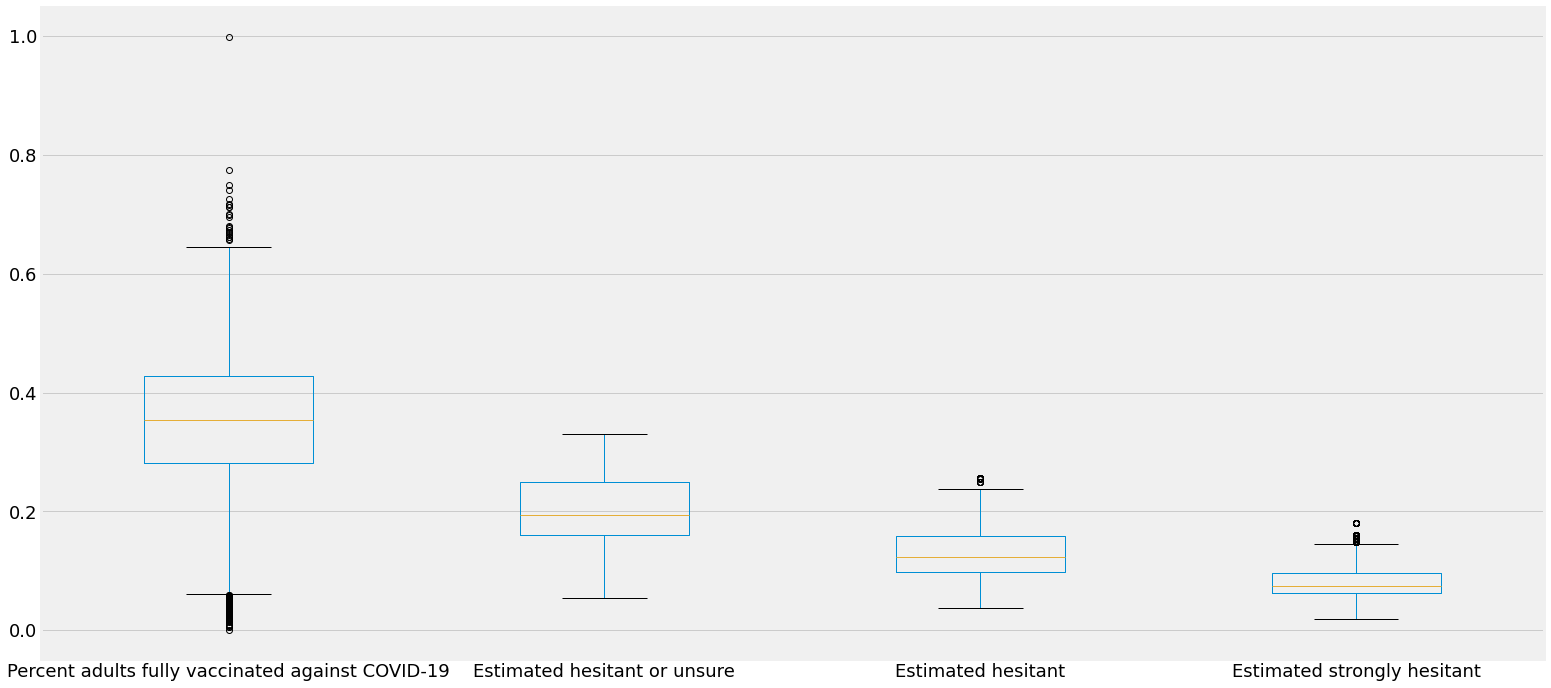

In [95]:
#Use boxplots to look for outliers
fig, ax = plt.subplots(1, figsize=(24,12))
df_cdc.boxplot(['Percent adults fully vaccinated against COVID-19','Estimated hesitant or unsure','Estimated hesitant','Estimated strongly hesitant'])
plt.grid(b=False, which='both', axis='x')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [96]:
#View outlier 
df_cdc[df_cdc['Percent adults fully vaccinated against COVID-19']>0.8]

,FIPS Code,County_Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,...,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,County Boundary,State Boundary
268,13053,"Chattahoochee County, Georgia",GEORGIA,0.1505,0.2546,0.0833,0.64,High Vulnerability,0.66,High Concern,...,0.1586,0.0028,0.0289,0.1988,0.0014,0.5758,POINT (-83.426574 32.638481),GA,"MULTIPOLYGON (((-84.888246 32.25967, -84.88851...","MULTIPOLYGON (((-85.38658099999999 33.901719, ..."


## Outlier Analysis 
In the box plots we see that the percent vaccinated has a number of points that the plot considers outliers, however since they appear to be grouped together and become less common the further they are from the mean. We're comfortable leaving these in the data as counties that are far ahead or behind in vaccination are important to keep in our analysis, even if it means a few of them may be reporting errors. The one point I will consider for removal is the county with almost 100% vaccination. This county is Chattahoochee County in Georgia. Considering it's vaccination hesitency is above average I am assuming this is a reporting error and will remove the county from the data. None of the hesitency columns have any points I consider necessary for removal. 

In [97]:
#remove outlier
df_cdc_2 = df_cdc[df_cdc['FIPS Code']!=13053]

## Cleaning the COVID County Info Data - Null Values - Social Vulnerability Index
Looking at the non-null values from the info printout we see five columns that contain null values: `Percent adults fully vaccinated against COVID-19`, `Social Vulnerability Index (SVI)`, `SVI Category`, `County Boundary`, and `State Boundary`. The first of these three has 316 null values and the remaining four have one each. We'll start by checking on SVI info, then the state and county boundary missing values. Finally, we'll investigate the fully vaccinated null values by looking into whether they are more common in specific states.

In [98]:
#View SVI null value
df_cdc_2[df_cdc_2['Social Vulnerability Index (SVI)'].isnull()]

,FIPS Code,County_Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,...,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,County Boundary,State Boundary
1874,35039,"Rio Arriba County, New Mexico",NEW MEXICO,0.0777,0.1079,0.0492,NaN,NaN,0.62,High Concern,...,0.7124,0.1431,0.0048,0.0044,0.0003,0.1244,POINT (-106.108388 34.421369),NM,"MULTIPOLYGON (((-106.985514 37.000083, -106.87...","MULTIPOLYGON (((-106.006316 36.995267, -105.96..."


## Addressing the SVI Null
There is one county missing this information and we confirmed on the [CDC SVI](https://svi.cdc.gov/map.html) website that there is no data for 2018. However, there is data from 2016 showing an SVI of .89 for Rio Arriba County, so we will use that year's index for our purposes and catorigize it as Very High based on the guidelines provided with the dataset:<br> 
Very Low (0.0 - 0.19)<br>
Low (0.20-0.39)<br>
Moderate (0.40-0.59)<br>
High (0.60-0.79)<br>
Very High (0.80-1.0)

In [99]:
#Update null value based on internet search
df_cdc_2.loc[df_cdc_2.County_Name == 'Rio Arriba County, New Mexico', 'Social Vulnerability Index (SVI)'] = .89
df_cdc_2.loc[df_cdc_2.County_Name == 'Rio Arriba County, New Mexico', 'SVI Category'] = 'Very High Vulnerability'

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## Cleaning the COVID County Info Data - Null Values - County and State Boundaries
We'll next take a look at the one missing value in the State and County Boundary column. 

In [100]:
#View County Boundary null
df_cdc_2[df_cdc_2['County Boundary'].isnull()]

,FIPS Code,County_Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,...,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,County Boundary,State Boundary
1931,35013,"Dona Ana County, New Mexico",NEW MEXICO,0.0838,0.1225,0.0512,0.98,Very High Vulnerability,0.66,High Concern,...,0.6826,0.0066,0.0105,0.0161,0.0003,0.2724,POINT (-106.108388 34.421369),NM,NaN,NaN


In [101]:
#View State Boundary null
df_cdc_2[df_cdc_2['State Boundary'].isnull()]

,FIPS Code,County_Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,...,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,County Boundary,State Boundary
1931,35013,"Dona Ana County, New Mexico",NEW MEXICO,0.0838,0.1225,0.0512,0.98,Very High Vulnerability,0.66,High Concern,...,0.6826,0.0066,0.0105,0.0161,0.0003,0.2724,POINT (-106.108388 34.421369),NM,NaN,NaN


## Data Cleaning Cont - Visualizing Missing Vaccination Data - Step 1: Convert to GeoDataFrame
We see that it's one county, Dona Ana County, New Mexico that is missing this geographic data and is also missing the percent of adults full vaccinated, so we'll drop it from our analysis. Our next step will be to investigate the remaining missing vaccination information. We'll first do this by converting the dataframe to a GeoDataFrame and visualizing all the counties on a map with the percent of adults fully vaccinated shaded by color. Null values will not be included. This will allow us to get an initial picture of the missing data. 

In [102]:
#Remove the one null county boundary row
clean_geo_county = df_cdc_2[df_cdc_2['County Boundary'].notnull()]
clean_geo_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3140 entries, 0 to 3141
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   FIPS Code                                              3140 non-null   int64  
 1   County_Name                                            3140 non-null   object 
 2   State                                                  3140 non-null   object 
 3   Estimated hesitant                                     3140 non-null   float64
 4   Estimated hesitant or unsure                           3140 non-null   float64
 5   Estimated strongly hesitant                            3140 non-null   float64
 6   Social Vulnerability Index (SVI)                       3140 non-null   float64
 7   SVI Category                                           3140 non-null   object 
 8   CVAC level of concern for vaccination rollout   

Pandas Apply:   0%|          | 0/3140 [00:00<?, ?it/s]

<ipython-input-103-6a4159ce74b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_geo_county['geometry'] = clean_geo_county['County Boundary'].swifter.apply(lambda x: wkt.loads(x))


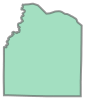

In [103]:
#Convert County geomteries into a geometry GeoSeries in geopandas. 
clean_geo_county['geometry'] = clean_geo_county['County Boundary'].swifter.apply(lambda x: wkt.loads(x))
clean_geo_county['geometry'].iloc[0]

We'll finish converting the dataframe into a GeoDataFrame with geopandas and will remove the two now unnecessary State and County Boundary columns.

In [104]:
#Convert entire DataFrame into a GeoDataFrame with the counties as the geometries
county_geoframe = gpd.GeoDataFrame(clean_geo_county, crs='epsg:4326', geometry='geometry')
county_geoframe.drop(['County Boundary','State Boundary'], axis=1, inplace=True)
county_geoframe.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3140 entries, 0 to 3141
Data columns (total 20 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   FIPS Code                                              3140 non-null   int64   
 1   County_Name                                            3140 non-null   object  
 2   State                                                  3140 non-null   object  
 3   Estimated hesitant                                     3140 non-null   float64 
 4   Estimated hesitant or unsure                           3140 non-null   float64 
 5   Estimated strongly hesitant                            3140 non-null   float64 
 6   Social Vulnerability Index (SVI)                       3140 non-null   float64 
 7   SVI Category                                           3140 non-null   object  
 8   CVAC level of concern for vacc

## Data Cleaning Cont - Visualizing Missing Vaccination Data - Step 2: Plot and Analyze GeoDataFrame
We can see in the map visualization that Texas and Hawaii appear to be missing data completly. Outside of those states data appears to be missing sporadically, but primarily in California. We'll take a look at these additional missing counties on a state by state count basis to get more specific. We'll do this by creating a dataframe with just the state and vaccination percentage info and then filtering to view thw null values and counting by state. We'll also count the number of counties in each state (the number of times each state appears in the dataframe, so we can get a sense for how many counties out of the total number in the state are missing. 

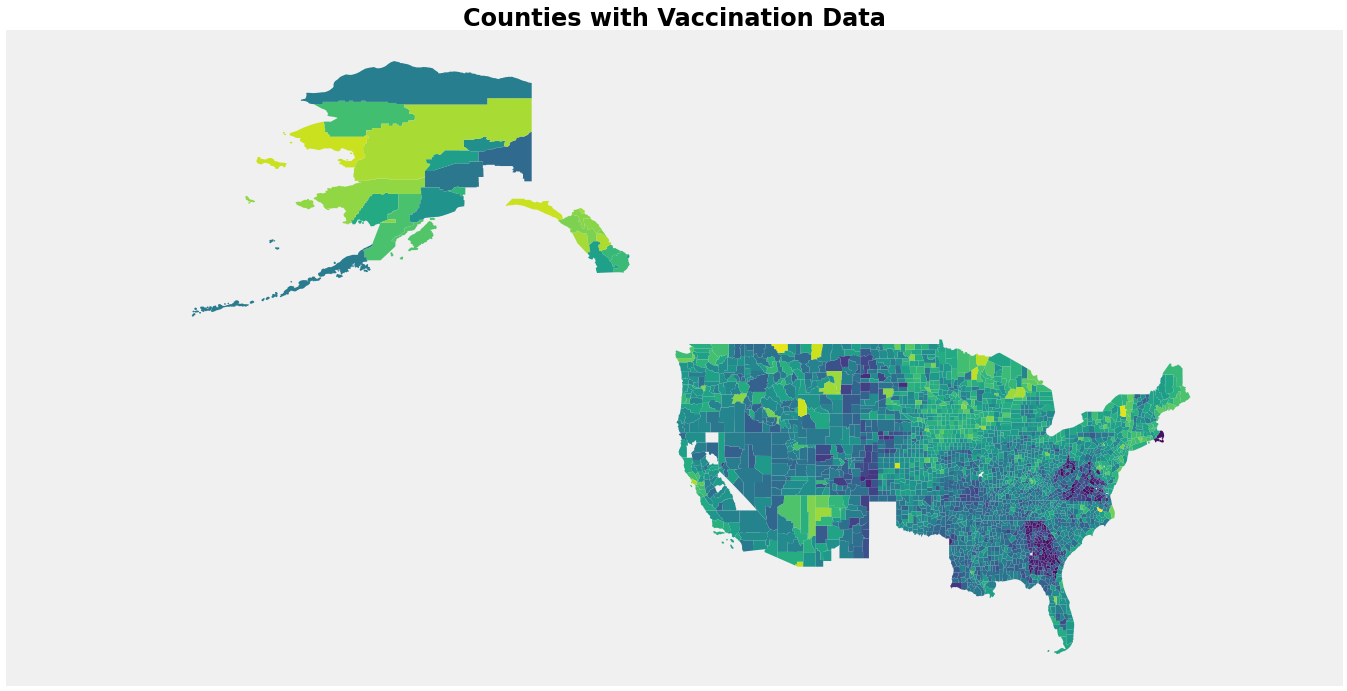

In [105]:
#Visualize vaccination data on a map to look for geographic areas with missing data
fig, ax = plt.subplots(1, figsize=(24,12))
ax = county_geoframe.plot(axes=ax, column='Percent adults fully vaccinated against COVID-19')
plt.grid(b=False, which='both')
plt.title("Counties with Vaccination Data", fontsize=24, fontweight=750)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.xlim([-200,-50])
plt.show()

<b>Review vaccination data map</b><br>
We see that it looks like all of Texas and Hawaii are missing as a well as a few individual counties around the country. We'll validate by counting the number missing from each state.

In [106]:
#Count the number of times each state appears in the dataframe. This is the number of counties in the state
df_cdc['State Code'].value_counts(dropna=False)

TX    254
GA    159
VA    133
KY    120
MO    115
KS    105
IL    102
NC    100
IA     99
TN     95
NE     93
IN     92
OH     88
MN     87
MI     83
MS     82
OK     77
AR     75
WI     72
FL     67
PA     67
AL     67
SD     66
CO     64
LA     64
NY     62
CA     58
MT     56
WV     55
ND     53
SC     46
ID     44
WA     39
OR     36
NM     33
UT     29
AK     29
MD     24
WY     23
NJ     21
NV     17
ME     16
AZ     15
VT     14
MA     14
NH     10
CT      8
HI      5
RI      5
DE      3
DC      1
Name: State Code, dtype: int64

In [107]:
'''Create dataframe of counties with missing vaccination data. Count the number of missing counties per state.''' 

null_vacc = df_cdc[df_cdc['Percent adults fully vaccinated against COVID-19'].isnull()]
null_vacc['State Code'].value_counts()

TX    254
VA     10
CA      8
HI      5
AK      2
Name: State Code, dtype: int64

### Notes on these states
This confirms all vaccination data in Texas, and Hawaii is missing. <br>
This is 10 of 95 counties in VA.<br>
This is 8 of 58 counties in CA.<br> 
This is 2 of 39 counties in AK. <br><br>

<b>Dealing with Missing Data</b><br>
The New York Times has similar vaccination analysis on their website and they note that Texas makes their vaccination data available by county available through the [Texas Health and Human Services website](https://www.dshs.texas.gov/coronavirus/immunize/vaccine.aspx), so we can download that data from there to resolve the issue of Texas. <br>
Unforetunately we'll have to drop the all the counties from Hawaii and will not be able to include Hawaii in our analysis. <br>
To evaluate the other states with missing counties we'll bring in population data to see if it makes sense to replace these missing counties with the state average, drop the counties, or drop the state entirely. <br>


In [108]:
#Removing Hawaii data because vaccination data is not included
county_geoframe = county_geoframe[~county_geoframe['State'].isin(['HAWAII'])]

## Bringing in Texas Data, Cleaning, and Merging

In [109]:
'''Texas makes their data available through their website, so we will read it in, clean it, and incorporate it.'''
df_texas = pd.read_csv('Texas COVID-19 Vaccine Data by County - By County.csv')
print(len(df_texas.index))
df_texas.head()

255


,County Name,Total Doses Allocated,Vaccine Doses Administered,People Vaccinated with at least One Dose,People Fully Vaccinated,Population\n12+,"Population, 16+","Population, 65+","Population, Phase 1A Healthcare Workers","Population, Phase 1A Long-term Care Residents","Population, 16-64\n Any Medical Condition",Population Education and Child Care Personnel
0,Anderson,"17,870","27,084","16,550","12,079","50,661","48,045","8,658","2,051",833,"20,206","1,574"
1,Andrews,"6,100","11,001","6,015","5,186","14,863","13,503","1,833",309,106,"5,450",41
2,Angelina,"58,100","47,739","26,866","22,578","72,486","67,056","14,422","6,534","1,752","28,054","3,266"
3,Aransas,"6,840","19,920","11,281","9,297","20,834","19,803","6,791",370,252,"6,701",39
4,Archer,"3,200","5,615","3,088","2,827","7,388","6,921","1,677",80,13,"2,381",330


In [110]:
df_texas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 12 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   County Name                                    255 non-null    object
 1   Total Doses Allocated                          254 non-null    object
 2   Vaccine Doses Administered                     255 non-null    object
 3   People Vaccinated with at least One Dose       255 non-null    object
 4   People Fully Vaccinated                        255 non-null    object
 5   Population
12+                                 254 non-null    object
 6   Population, 16+                                254 non-null    object
 7   Population, 65+                                254 non-null    object
 8   Population, Phase 1A Healthcare Workers        254 non-null    object
 9   Population, Phase 1A Long-term Care Residents  254 non-null    ob

In [111]:
#Look at the null row
df_texas[df_texas['Population, Phase 1A Healthcare Workers'].isnull()]

,County Name,Total Doses Allocated,Vaccine Doses Administered,People Vaccinated with at least One Dose,People Fully Vaccinated,Population\n12+,"Population, 16+","Population, 65+","Population, Phase 1A Healthcare Workers","Population, Phase 1A Long-term Care Residents","Population, 16-64\n Any Medical Condition",Population Education and Child Care Personnel
254,Other,NaN,"246,858","161,666","99,863",NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning Texas Vaccination Data
On first inspection of the Texas data we see that we have one more row than there are counties in Texas. By inspecting the nulls in the data we find that there is a row for 'Other', which we will remove, leaving us with only the 254 counties in Texas. <br>
There are a number of columns in the Texas data, but we are only interested in three: County Name, People Fully Vaccinated, and Population, 16+. We will use County Name to match with the county names in our COVID data and merge the data sets. We'll use the other two columns to make an approximatation of percent of adults fully vaccinated in each county. In order to use these columns for these purposes they will need a little reformatting. The County Names don't include the word county and there is not a column with the FIPS code. As a result we will have to add the word County, a comma, and 'Texas' to the county names before merging to match the CDC data. The population and and vaccination numbers are currently strings with a comma in them, so they will need to have the comma removed and be converted to integers before we can divide the number of fully vaccinated by the population of 16 and older individuals. <br><br>

In [112]:
#Remove 'Other' row
df_texas = df_texas[~(df_texas['County Name']=='Other')]


In [113]:
#Format county names to match COVID Data
df_texas['County Name'] = df_texas['County Name'] + ' County, Texas'
#Convert vaccinated number and population 16+ to integer
df_texas['People Fully Vaccinated'] = df_texas['People Fully Vaccinated'].str.replace(',','').astype(int)
df_texas['Population, 16+'] = df_texas['Population, 16+'].str.replace(',','').astype(int)
#Create column for percent of adults (16+) fully vaccinated
df_texas['TX adults fully vaccinated against COVID-19'] = df_texas['People Fully Vaccinated'] / df_texas['Population, 16+']
#Change County Name column to match name in COVID data
df_texas = df_texas.rename(mapper={'County Name':'County_Name'}, axis=1)
#Make final dataframe with the two relevent columns, county_name and percent full vaccinated adults
final_df_texas = df_texas[['County_Name','TX adults fully vaccinated against COVID-19']]
final_df_texas.head()

,County_Name,TX adults fully vaccinated against COVID-19
0,"Anderson County, Texas",0.251410
1,"Andrews County, Texas",0.384063
2,"Angelina County, Texas",0.336704
3,"Aransas County, Texas",0.469474
4,"Archer County, Texas",0.408467


Merge Texas county data with COVID data from CDC. After merging we will then fill the null values in the Percent adults fully vaccinated against COVID-19 column with the values in the new column we've created with the Texas data. For rows that have data in the texas column and are null in the CDC fully vaccinated column, which is all counties in Texas, this will bring the data over into our working column, leaving all existing values intact. 

In [114]:
#Merge Texas data with our GeoDataFrame
county_geoframe = county_geoframe.merge(right=final_df_texas, how='left', on = ['County_Name'])
county_geoframe.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3135 entries, 0 to 3134
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   FIPS Code                                              3135 non-null   int64   
 1   County_Name                                            3135 non-null   object  
 2   State                                                  3135 non-null   object  
 3   Estimated hesitant                                     3135 non-null   float64 
 4   Estimated hesitant or unsure                           3135 non-null   float64 
 5   Estimated strongly hesitant                            3135 non-null   float64 
 6   Social Vulnerability Index (SVI)                       3135 non-null   float64 
 7   SVI Category                                           3135 non-null   object  
 8   CVAC level of concern for vacc

In [115]:
#Fill nulls in the fully vaccinated column with values in the Texas vaccinated column (if applicable)
county_geoframe['Percent adults fully vaccinated against COVID-19'].fillna(county_geoframe['TX adults fully vaccinated against COVID-19'], inplace=True)
county_geoframe.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3135 entries, 0 to 3134
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   FIPS Code                                              3135 non-null   int64   
 1   County_Name                                            3135 non-null   object  
 2   State                                                  3135 non-null   object  
 3   Estimated hesitant                                     3135 non-null   float64 
 4   Estimated hesitant or unsure                           3135 non-null   float64 
 5   Estimated strongly hesitant                            3135 non-null   float64 
 6   Social Vulnerability Index (SVI)                       3135 non-null   float64 
 7   SVI Category                                           3135 non-null   object  
 8   CVAC level of concern for vacc

In [116]:
#Drop column with just TX data and confirm there are no null vaccination data points in Texas in the full vacc column
county_geoframe.drop(labels='TX adults fully vaccinated against COVID-19', axis=1, inplace=True)
vacc_missing = county_geoframe[county_geoframe['Percent adults fully vaccinated against COVID-19'].isnull()]
vacc_missing['State Code'].value_counts()

VA    10
CA     8
AK     2
Name: State Code, dtype: int64

## Read and Clean County Population Data
Our next step is to bring in county population data from the US Census to merge with our existing dataset. This will allow us better understand the size and impact of the remaining missing 20 counties. The data was downloaded from the United States Census Bureau and can be found [here](https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-total.html). This data set includes population data for all of the counties in the United States, to match our COVID info dataset.

In [117]:
'''We are now incorporating population data from the census for each county. We start by reading in the data.'''
df_county_pops = pd.read_csv('census_county_pop_ann.csv')
df_county_pops.head()

,Unnamed: 0,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,United States,"308,745,538","308,758,105","309,321,666","311,556,874","313,830,990","315,993,715","318,301,008","320,635,163","322,941,311","324,985,539","326,687,501","328,239,523"
1,".Autauga County, Alabama","54,571","54,597","54,773","55,227","54,954","54,727","54,893","54,864","55,243","55,390","55,533","55,869"
2,".Baldwin County, Alabama","182,265","182,265","183,112","186,558","190,145","194,885","199,183","202,939","207,601","212,521","217,855","223,234"
3,".Barbour County, Alabama","27,457","27,455","27,327","27,341","27,169","26,937","26,755","26,283","25,806","25,157","24,872","24,686"
4,".Bibb County, Alabama","22,915","22,915","22,870","22,745","22,667","22,521","22,553","22,566","22,586","22,550","22,367","22,394"


## Population Data - Data Cleaning
At a high level we need to format the data so that we have the correct data, so that it will merge cleanly, and ensure the data is the correct type for analysis. We'll start by renaming the County Name and 2019 (population) columns, removing the row for the entire United States, and creating a new data frame with just the county names and 2019 populations. 

In [118]:
'''Changing the county name column so it matches our other dataset and changing the 2019 pop for clarity. 
Dropping the United States row as it is unnecessary.'''
column_mapper_2 = {'Unnamed: 0':'County_Name', '2019':'2019_pop'}
df_county_pops.rename(columns=column_mapper_2, inplace=True)
df_county_pops.drop(df_county_pops[df_county_pops.County_Name=='United States'].index, inplace=True)
df_county_pops.head()

,County_Name,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019_pop
1,".Autauga County, Alabama","54,571","54,597","54,773","55,227","54,954","54,727","54,893","54,864","55,243","55,390","55,533","55,869"
2,".Baldwin County, Alabama","182,265","182,265","183,112","186,558","190,145","194,885","199,183","202,939","207,601","212,521","217,855","223,234"
3,".Barbour County, Alabama","27,457","27,455","27,327","27,341","27,169","26,937","26,755","26,283","25,806","25,157","24,872","24,686"
4,".Bibb County, Alabama","22,915","22,915","22,870","22,745","22,667","22,521","22,553","22,566","22,586","22,550","22,367","22,394"
5,".Blount County, Alabama","57,322","57,322","57,376","57,560","57,580","57,619","57,526","57,526","57,494","57,787","57,771","57,826"


In [119]:
#Creating a new dataframe with only the relevant columns: County Name and 2019 Population.
df_county_pop_2019 = df_county_pops[['County_Name','2019_pop']].copy()
df_county_pop_2019.head()

,County_Name,2019_pop
1,".Autauga County, Alabama","55,869"
2,".Baldwin County, Alabama","223,234"
3,".Barbour County, Alabama","24,686"
4,".Bibb County, Alabama","22,394"
5,".Blount County, Alabama","57,826"


## Population Data - Data Cleaning - County_Name.
Remove leading period from county name and convert the population column to an integer by removing the comma and converting to an integer. Finally, we'll confirm we have the correct number of rows. We have 2 more than our dataframe we'll be merging with, but that is to be expected as we removed two counties in our cleaning of that data. 

In [120]:
#Stripping the period that was included before each county name.
df_county_pop_2019['County_Name'] = df_county_pops['County_Name'].str[1:]
df_county_pop_2019.head()

,County_Name,2019_pop
1,"Autauga County, Alabama","55,869"
2,"Baldwin County, Alabama","223,234"
3,"Barbour County, Alabama","24,686"
4,"Bibb County, Alabama","22,394"
5,"Blount County, Alabama","57,826"


In [121]:
#Convert population to an integer by removing the commas and converting to integer
df_county_pop_2019['2019_pop'] = df_county_pop_2019['2019_pop'].str.replace(',','').astype(int)

In [122]:
#Confirming we have the same number of rows in the population dataframe as the COVID info dataframe
df_county_pop_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 1 to 3142
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   County_Name  3142 non-null   object
 1   2019_pop     3142 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 73.6+ KB


## Merge Population Data with COVID GeoDataFrame on County Name

In [123]:
#Create the combined dataframe by merging the population df with the COVID info GeoDataFrame.
final_df = county_geoframe.merge(right=df_county_pop_2019, how='left', on =['County_Name'])
final_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3135 entries, 0 to 3134
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   FIPS Code                                              3135 non-null   int64   
 1   County_Name                                            3135 non-null   object  
 2   State                                                  3135 non-null   object  
 3   Estimated hesitant                                     3135 non-null   float64 
 4   Estimated hesitant or unsure                           3135 non-null   float64 
 5   Estimated strongly hesitant                            3135 non-null   float64 
 6   Social Vulnerability Index (SVI)                       3135 non-null   float64 
 7   SVI Category                                           3135 non-null   object  
 8   CVAC level of concern for vacc

## Checking if any rows didn't match on the merge
We see that there is one row with a missing population value. We'll view that row and then check if it exist's in our original population dataframe. 

In [124]:
final_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3135 entries, 0 to 3134
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   FIPS Code                                              3135 non-null   int64   
 1   County_Name                                            3135 non-null   object  
 2   State                                                  3135 non-null   object  
 3   Estimated hesitant                                     3135 non-null   float64 
 4   Estimated hesitant or unsure                           3135 non-null   float64 
 5   Estimated strongly hesitant                            3135 non-null   float64 
 6   Social Vulnerability Index (SVI)                       3135 non-null   float64 
 7   SVI Category                                           3135 non-null   object  
 8   CVAC level of concern for vacc

In [125]:
'''We see that there is one null county population, 
so we'll take a look at them to see if we can fill them in manually.''' 
final_df[final_df['2019_pop'].isnull()]

,FIPS Code,County_Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,...,Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,geometry,2019_pop
2101,38009,"Bottineau County, North Dakota",NORTH DAKOTA,0.2065,0.2939,0.1296,0.07,Very Low Vulnerability,0.14,Very Low Concern,...,0.0231,0.0412,0.0011,0.006,0.0,0.9134,POINT (-100.46931 47.446305),ND,"MULTIPOLYGON (((-101.49657 48.80714, -101.4965...",NaN


In [126]:
#Search the population dataframe for the missing counties
df_county_pops[df_county_pops['County_Name'].str.contains('Bottineau')]

,County_Name,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019_pop
1995,"Bottineau County, North Dakota","6,429","6,429","6,440","6,499","6,606","6,738","6,684","6,734","6,573","6,522","6,398","6,282"


## Population Data - Updating Missing Values
The missing county is in our original population data, so we'll update it manually in this dataframe.

In [127]:
#Updating null values and confirming there are no additional nulls
final_df.loc[final_df.County_Name == 'Bottineau County, North Dakota', '2019_pop'] = 6282
final_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3135 entries, 0 to 3134
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   FIPS Code                                              3135 non-null   int64   
 1   County_Name                                            3135 non-null   object  
 2   State                                                  3135 non-null   object  
 3   Estimated hesitant                                     3135 non-null   float64 
 4   Estimated hesitant or unsure                           3135 non-null   float64 
 5   Estimated strongly hesitant                            3135 non-null   float64 
 6   Social Vulnerability Index (SVI)                       3135 non-null   float64 
 7   SVI Category                                           3135 non-null   object  
 8   CVAC level of concern for vacc

## Use Population Data to Inspect Impact of Counties Missing Vaccination Data
Now that we have population data we can make some more informed decisions regarding how to handle our counties/states missing vaccination data. To recap, we've dropped Hawaii and have missing counties in three states: Virgina (10 counties), California (8), and Alaska (2). Our plan is to determine if these counties make up a large proportion of these states populations which might lead us to dropping all the state data, or if they are small counties we may just drop the counties individually as they make up a small number (less than 1%) of the nationwide counties. We'll find the state populations, the population that live in the missing counties, and then a percentage of the missing data. 

In [128]:
'''Displaying number of counties per state with missing vaccination data (that we have not already removed) 
for reference'''
county_geoframe['State'][county_geoframe[['Percent adults fully vaccinated against COVID-19','State Code']]['Percent adults fully vaccinated against COVID-19'].isnull()].value_counts()

VIRGINIA      10
CALIFORNIA     8
ALASKA         2
Name: State, dtype: int64

In [129]:
#Calcualte the total population in each state in the counties that are missing vaccination data
va_counties = final_df[final_df['State']=='VIRGINIA']
va_pop = va_counties['2019_pop'].sum()
ca_counties = final_df[final_df['State']=='CALIFORNIA']
ca_pop = ca_counties['2019_pop'].sum()
ak_counties = final_df[final_df['State']=='ALASKA']
ak_pop = ak_counties['2019_pop'].sum()
print('Virginia Pop:',va_pop)
print('California Pop:',ca_pop)
print('Alaska Pop:',ak_pop)

Virginia Pop: 8535519.0
California Pop: 39512223.0
Alaska Pop: 731545.0


In [130]:
#Counties from each state with missing vaccination data
va_missing_vacc_counties = va_counties[va_counties['Percent adults fully vaccinated against COVID-19'].isnull()]
ca_missing_vacc_counties = ca_counties[ca_counties['Percent adults fully vaccinated against COVID-19'].isnull()]
ak_missing_vacc_counties = ak_counties[ak_counties['Percent adults fully vaccinated against COVID-19'].isnull()]
#Population in those counties from each state (missing vaccination data)
va_missing_pop = va_missing_vacc_counties['2019_pop'].sum()
ca_missing_pop = ca_missing_vacc_counties['2019_pop'].sum()
ak_missing_pop = ak_missing_vacc_counties['2019_pop'].sum()
#Percent of each states population that is missing vaccination data
percent_va_missing = round(100*(va_missing_pop/va_pop),2)
percent_ca_missing = round(100*(ca_missing_pop/ca_pop),2)
percent_ak_missing = round(100*(ak_missing_pop/ak_pop),2)
print('Percent of Virgina Population Missing Vaccine Data:',percent_va_missing)
print('Percent of California Population Missing Vaccine Data:',percent_ca_missing)
print('Percent of Alaska Population Missing Vaccine Data:',percent_ak_missing)


Percent of Virgina Population Missing Vaccine Data: 1.06
Percent of California Population Missing Vaccine Data: 0.24
Percent of Alaska Population Missing Vaccine Data: 2.39


## Evaluation of Missing Data Based on Population
We have determined that these counties make up a very small percentage of the total population of the state (between .24 and 2.39 percent) and feel comfortable replacing them or removing them from our final analysis as we feel the overall impact would be low. We considered two options for replacing these vaccine rates: With the state average, or with an average of a group of counties in the same state with a similar Social Vulnerability Index. <br><br>
Utimately it was decided to remove these counties from the analysis entirely. Based on their very small number and size, it is not necessary to include them in our analysis and excluding them will not have a large impact on any conclusions we made be able to draw, as we are looking for wide spread trends. 

## Adding 2016 Voting Data
Before starting our analysis we'll add our final piece of data to the dataset: the political leaning of each county based on 2016 voting records. COVID and Vaccination has been a highly politicized issue, so we're interested on seeing if voting records correlate with vaccine hesitency or vaccine rates. The MIT Election Data Lab has a dataset of county voting records from 2000-2016 that we will use to estimate each counties political leanings. That data can be found on the MIT Election Lab website [here](https://electionlab.mit.edu/data). <br><br>
The data has a few columns we're interested in:<br>
<b>year:</b> The year of the election the data in the row contains.<br>
<b>FIPS:</b> The FIPS code for the county the row contains data for.<br>
<b>party:</b> The party of the candidate the row contains county voting data for.<br>
<b>candidatevotes:</b> The number of votes the candidate recieved in this county in this row's year.<br>
<b>totalvotes:</b> The total votes cast for all candidates in this county in this year.<br>

We'll read the dataset in as a dataframe and then inspect it to establish our next steps. 

In [131]:
'''We are now adding in 2016 voting data as a proxy for county political leaning. 
We start by reading in the data as a data frame.'''
df_politics = pd.read_csv('countypres_2000-2016.csv')
df_politics.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
0,2000,Alabama,AL,Autauga,1001.0,President,Al Gore,democrat,4942.0,17208,20191203
1,2000,Alabama,AL,Autauga,1001.0,President,George W. Bush,republican,11993.0,17208,20191203
2,2000,Alabama,AL,Autauga,1001.0,President,Ralph Nader,green,160.0,17208,20191203
3,2000,Alabama,AL,Autauga,1001.0,President,Other,NaN,113.0,17208,20191203
4,2000,Alabama,AL,Baldwin,1003.0,President,Al Gore,democrat,13997.0,56480,20191203


In [132]:
#Create a dataframe with just 2016 voting data
df_politics_2016 = df_politics[df_politics['year']==2016]
df_politics_2016.isna().sum()

year                 0
state                0
state_po            12
county               0
FIPS                 9
office               0
candidate            0
party             3158
candidatevotes       6
totalvotes           0
version              0
dtype: int64

### Viewing null values for FIPS, party, state_po, and votes

In [133]:
#Check null FIPS counties
null_fips = df_politics_2016[df_politics_2016['FIPS'].isnull()]
null_fips.head(10)

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
49859,2016,Connecticut,NaN,Statewide writein,NaN,President,Hillary Clinton,democrat,NaN,5056,20191203
49860,2016,Maine,NaN,Maine UOCAVA,NaN,President,Hillary Clinton,democrat,3017.0,5056,20191203
49861,2016,Rhode Island,NaN,Federal Precinct,NaN,President,Hillary Clinton,democrat,637.0,5056,20191203
49862,2016,Connecticut,NaN,Statewide writein,NaN,President,Donald Trump,republican,NaN,5056,20191203
49863,2016,Maine,NaN,Maine UOCAVA,NaN,President,Donald Trump,republican,648.0,5056,20191203
49864,2016,Rhode Island,NaN,Federal Precinct,NaN,President,Donald Trump,republican,53.0,5056,20191203
49865,2016,Connecticut,NaN,Statewide writein,NaN,President,Other,NaN,NaN,5056,20191203
49866,2016,Maine,NaN,Maine UOCAVA,NaN,President,Other,NaN,321.0,5056,20191203
49867,2016,Rhode Island,NaN,Federal Precinct,NaN,President,Other,NaN,38.0,5056,20191203


In [134]:
df_politics_2016[df_politics_2016['state_po'].isnull()]

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
49859,2016,Connecticut,NaN,Statewide writein,NaN,President,Hillary Clinton,democrat,NaN,5056,20191203
49860,2016,Maine,NaN,Maine UOCAVA,NaN,President,Hillary Clinton,democrat,3017.0,5056,20191203
49861,2016,Rhode Island,NaN,Federal Precinct,NaN,President,Hillary Clinton,democrat,637.0,5056,20191203
49862,2016,Connecticut,NaN,Statewide writein,NaN,President,Donald Trump,republican,NaN,5056,20191203
49863,2016,Maine,NaN,Maine UOCAVA,NaN,President,Donald Trump,republican,648.0,5056,20191203
49864,2016,Rhode Island,NaN,Federal Precinct,NaN,President,Donald Trump,republican,53.0,5056,20191203
49865,2016,Connecticut,NaN,Statewide writein,NaN,President,Other,NaN,NaN,5056,20191203
49866,2016,Maine,NaN,Maine UOCAVA,NaN,President,Other,NaN,321.0,5056,20191203
49867,2016,Rhode Island,NaN,Federal Precinct,NaN,President,Other,NaN,38.0,5056,20191203
50521,2016,Alaska,NaN,District 99,2099.0,President,Hillary Clinton,democrat,274.0,5056,20191203


In [135]:
#Check values in the party column
df_politics_2016['party'].value_counts()


republican    3158
democrat      3158
Name: party, dtype: int64

In [136]:
#Investigate what is going on with party column null values. We see they are write in candidate and can be dropped.
party_nulls = df_politics_2016[df_politics_2016['party'].isnull()]
party_nulls.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
40519,2016,Alabama,AL,Autauga,1001.0,President,Other,NaN,865.0,24973,20191203
40522,2016,Alabama,AL,Baldwin,1003.0,President,Other,NaN,3874.0,95215,20191203
40525,2016,Alabama,AL,Barbour,1005.0,President,Other,NaN,144.0,10469,20191203
40528,2016,Alabama,AL,Bibb,1007.0,President,Other,NaN,207.0,8819,20191203
40531,2016,Alabama,AL,Blount,1009.0,President,Other,NaN,573.0,25588,20191203


In [137]:
#View 6 null candidatevotes rows
null_votes = df_politics_2016[df_politics_2016['candidatevotes'].isnull()]
null_votes.head(10)

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
49178,2016,Virginia,VA,Bedford,51515.0,President,Hillary Clinton,democrat,NaN,0,20191203
49179,2016,Virginia,VA,Bedford,51515.0,President,Donald Trump,republican,NaN,0,20191203
49180,2016,Virginia,VA,Bedford,51515.0,President,Other,NaN,NaN,0,20191203
49859,2016,Connecticut,NaN,Statewide writein,NaN,President,Hillary Clinton,democrat,NaN,5056,20191203
49862,2016,Connecticut,NaN,Statewide writein,NaN,President,Donald Trump,republican,NaN,5056,20191203
49865,2016,Connecticut,NaN,Statewide writein,NaN,President,Other,NaN,NaN,5056,20191203


## Handling Null Values
1. FIPS null rows are not real counties and therefore can be removed. <br>
2. Party null values are for non-major parties and can be removed as we're only interested in the two main parties for simplicities sake.<br>
3. There are 6 nulls in the cadidatevotes column. Three are for a statewide writein county, which is irrelevant to us, and the other is for Bedford, VA. Because this issue only impacts one county we will just drop all counties with null values in the candidatevotes column. 
4. State_po null values are null FIP codes or not real counties, so I'll drop these counties. 

In [138]:
#Dropping all rows with nulls in either the FIPS, party, or candidatevotes column. 
df_politics_2016 = df_politics_2016.dropna(axis=0, subset=['FIPS', 'party', 'candidatevotes', 'state_po'])
df_politics_2016.isna().sum()


year              0
state             0
state_po          0
county            0
FIPS              0
office            0
candidate         0
party             0
candidatevotes    0
totalvotes        0
version           0
dtype: int64

### Convert the FIPS column to an integer for merging dataframes. 

In [139]:
df_politics_2016['FIPS'] = df_politics_2016['FIPS'].astype(int)
df_politics_2016.head(10)

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
40517,2016,Alabama,AL,Autauga,1001,President,Hillary Clinton,democrat,5936.0,24973,20191203
40518,2016,Alabama,AL,Autauga,1001,President,Donald Trump,republican,18172.0,24973,20191203
40520,2016,Alabama,AL,Baldwin,1003,President,Hillary Clinton,democrat,18458.0,95215,20191203
40521,2016,Alabama,AL,Baldwin,1003,President,Donald Trump,republican,72883.0,95215,20191203
40523,2016,Alabama,AL,Barbour,1005,President,Hillary Clinton,democrat,4871.0,10469,20191203
40524,2016,Alabama,AL,Barbour,1005,President,Donald Trump,republican,5454.0,10469,20191203
40526,2016,Alabama,AL,Bibb,1007,President,Hillary Clinton,democrat,1874.0,8819,20191203
40527,2016,Alabama,AL,Bibb,1007,President,Donald Trump,republican,6738.0,8819,20191203
40529,2016,Alabama,AL,Blount,1009,President,Hillary Clinton,democrat,2156.0,25588,20191203
40530,2016,Alabama,AL,Blount,1009,President,Donald Trump,republican,22859.0,25588,20191203


## Create Column with Sum of Democratic and Republican Votes
We need a number to represent each county's policatal leanings based on their votes in the 2016 election. We are only looking at votes cast for either the Democratic or Republican candidates, so we will use the proportion of total votes cast for one of these two that was cast for the Republican as our political leaning proxy. In order to calculate this we will group on the county code and sum the candidate votes. This will leave us with a series of the total votes cast for the two main parties in each county with the FIPS code as the index of the series. We then convert the series to a dataframe making the FIPS code a column. We can then merge this dataframe with our full GeoDataFrame on the FIPS Code.


In [140]:
'''Group the 2016 Democratic and Republican votes on the FIPS Code and sum the group leaving us with a 
dataframe with a column for the total votes for the two parties in each county (among others) with 
the FIPS code as the index.'''
grouper_fips = df_politics_2016.groupby('FIPS')['candidatevotes'].sum().reset_index()
grouper_fips

,FIPS,candidatevotes
0,1001,24108.0
1,1003,91341.0
2,1005,10325.0
3,1007,8612.0
4,1009,25015.0
...,...,...
3148,56037,15385.0
3149,56039,11235.0
3150,56041,7356.0
3151,56043,3443.0


In [141]:
# Create Dataframe of votes for Democrat and Republican Candidate
grouper_fips = grouper_fips.rename(mapper={'candidatevotes': 'combined_votes'}, axis='columns')
grouper_fips.head()

,FIPS,combined_votes
0,1001,24108.0
1,1003,91341.0
2,1005,10325.0
3,1007,8612.0
4,1009,25015.0


In [142]:
#Merge dataframe back to full voting data frame and confirm there are no nulls in combined votes
full_df_politics_2016 = df_politics_2016.merge(right=grouper_fips, how='left', on=['FIPS'])
full_df_politics_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6306 entries, 0 to 6305
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            6306 non-null   int64  
 1   state           6306 non-null   object 
 2   state_po        6306 non-null   object 
 3   county          6306 non-null   object 
 4   FIPS            6306 non-null   int64  
 5   office          6306 non-null   object 
 6   candidate       6306 non-null   object 
 7   party           6306 non-null   object 
 8   candidatevotes  6306 non-null   float64
 9   totalvotes      6306 non-null   int64  
 10  version         6306 non-null   int64  
 11  combined_votes  6306 non-null   float64
dtypes: float64(2), int64(4), object(6)
memory usage: 640.5+ KB


<b>Create Column in Full Voting Dataframe with Proportion of Major Party Voters that Voted for that Row's Candidate</b>

In [143]:
full_df_politics_2016.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version,combined_votes
0,2016,Alabama,AL,Autauga,1001,President,Hillary Clinton,democrat,5936.0,24973,20191203,24108.0
1,2016,Alabama,AL,Autauga,1001,President,Donald Trump,republican,18172.0,24973,20191203,24108.0
2,2016,Alabama,AL,Baldwin,1003,President,Hillary Clinton,democrat,18458.0,95215,20191203,91341.0
3,2016,Alabama,AL,Baldwin,1003,President,Donald Trump,republican,72883.0,95215,20191203,91341.0
4,2016,Alabama,AL,Barbour,1005,President,Hillary Clinton,democrat,4871.0,10469,20191203,10325.0


In [144]:
'''Each row represents votes for a politacal party, so this will create a column with the proportion of 
votes cast for the two main parties cast for the party represented by each row.'''
full_df_politics_2016['proportion_party_votes'] = (full_df_politics_2016['candidatevotes']/
                                                   full_df_politics_2016['combined_votes'])

## Prep for Merging with Full Dataset
We can only merge one voting proportion with the full dataframe per county, so we will remove all rows that contain the votes for the Democratic candidate and leave just the Republican voting proportion. This means that from this point on voting ratio will refer to "proportion of total votes vast for either the Democratic or Republican candidate that were cast for the Republican candidate in this county".<br><br>
We will then remove all columns except for the FIPS code and the proportion votes column.

In [145]:
'''Create a final dataframe with just the rows with the Republican votes. We will merge this with our 
full GeoDataFrame of COVID data. Therefore the voting proportion we will be working with moving 
forward will represent the proportion of votes cast for either the Dem or Rep candidate in that 
county that was cast for the Rep candidate. We will also trim our merge dataframe down to just our 
two relevant columns and rename them in prepartion for merging. 
We also check the length to confirm we have around the right number of counties.'''

final_df_politics_2016 = full_df_politics_2016[full_df_politics_2016['party']=='republican']
final_df_politics_2016 = final_df_politics_2016[['FIPS','proportion_party_votes']]
final_df_politics_2016 = final_df_politics_2016.rename(mapper={'FIPS':'FIPS Code', 'proportion_party_votes':'prop_repub_votes'}, axis=1)
len(final_df_politics_2016.index)

3153

## Merge with Final County COVID and Pop GeoDataFrame

In [146]:
#Merge dataframes
final_df = final_df.merge(right=final_df_politics_2016, how='left', on=['FIPS Code'])
final_df.head()

,FIPS Code,County_Name,State,Estimated hesitant,Estimated hesitant or unsure,Estimated strongly hesitant,Social Vulnerability Index (SVI),SVI Category,CVAC level of concern for vaccination rollout,CVAC Level Of Concern,...,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,Geographical Point,State Code,geometry,2019_pop,prop_repub_votes
0,1079,"Lawrence County, Alabama",ALABAMA,0.1913,0.2762,0.0999,0.50,Moderate Vulnerability,0.80,High Concern,...,0.0560,0.0020,0.1058,0.0008,0.7649,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.52979 34.51852, -87.52978 ...",32924.0,0.749170
1,1107,"Pickens County, Alabama",ALABAMA,0.1825,0.2688,0.0917,0.92,Very High Vulnerability,0.78,High Concern,...,0.0014,0.0006,0.3984,0.0006,0.5365,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-88.29706 33.34908, -88.27886 ...",19930.0,0.578702
2,1035,"Conecuh County, Alabama",ALABAMA,0.1915,0.2943,0.0963,0.81,Very High Vulnerability,0.89,Very High Concern,...,0.0020,0.0045,0.4776,0.0000,0.5005,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.16566 31.54290, -87.16535 ...",12067.0,0.526154
3,4021,"Pinal County, Arizona",ARIZONA,0.1422,0.2077,0.0877,0.86,Very High Vulnerability,0.87,Very High Concern,...,0.0430,0.0158,0.0408,0.0029,0.5679,POINT (-111.664616 34.293239),AZ,"MULTIPOLYGON (((-111.68591 33.20464, -111.6191...",462789.0,0.603251
4,1067,"Henry County, Alabama",ALABAMA,0.1929,0.2871,0.0996,0.55,Moderate Vulnerability,0.65,High Concern,...,0.0018,0.0040,0.2655,0.0010,0.6917,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-85.41577 31.49041, -85.41534 ...",17205.0,0.710752


In [147]:
final_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3135 entries, 0 to 3134
Data columns (total 22 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   FIPS Code                                              3135 non-null   int64   
 1   County_Name                                            3135 non-null   object  
 2   State                                                  3135 non-null   object  
 3   Estimated hesitant                                     3135 non-null   float64 
 4   Estimated hesitant or unsure                           3135 non-null   float64 
 5   Estimated strongly hesitant                            3135 non-null   float64 
 6   Social Vulnerability Index (SVI)                       3135 non-null   float64 
 7   SVI Category                                           3135 non-null   object  
 8   CVAC level of concern for vacc

## Check States Missing Voting Data
Alaska has 26 counties missing voting data and South Dakota has one county. This will not impact our ability to do our analysis and we will continue. 

In [148]:
#Counties in which states that are missing voting data
missing_votes = final_df[final_df['prop_repub_votes'].isnull()]
missing_votes['State'].value_counts()

ALASKA          26
SOUTH DAKOTA     1
Name: State, dtype: int64

## Analyzing the Data
Now that all our data is clean and merged together we have reached the analysis portion of the investigation and will start by taking a look at the correlations between our variables. We're interested in primarily how these variables connect to vaccination rate, but will also look for anything other interesting correlations that arise. 

<AxesSubplot:xlabel='Social Vulnerability Index (SVI)', ylabel='Count'>

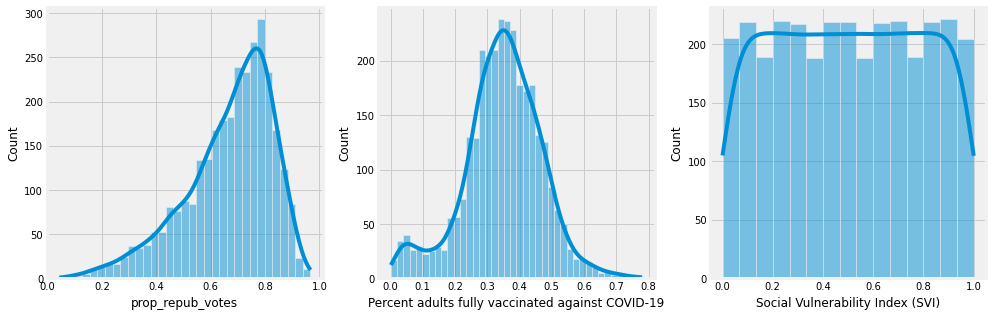

In [149]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.histplot(final_df['prop_repub_votes'], kde=True, ax=ax1)
sns.histplot(final_df['Percent adults fully vaccinated against COVID-19'], kde=True, ax=ax2)
sns.histplot(final_df['Social Vulnerability Index (SVI)'], kde=True, ax=ax3)

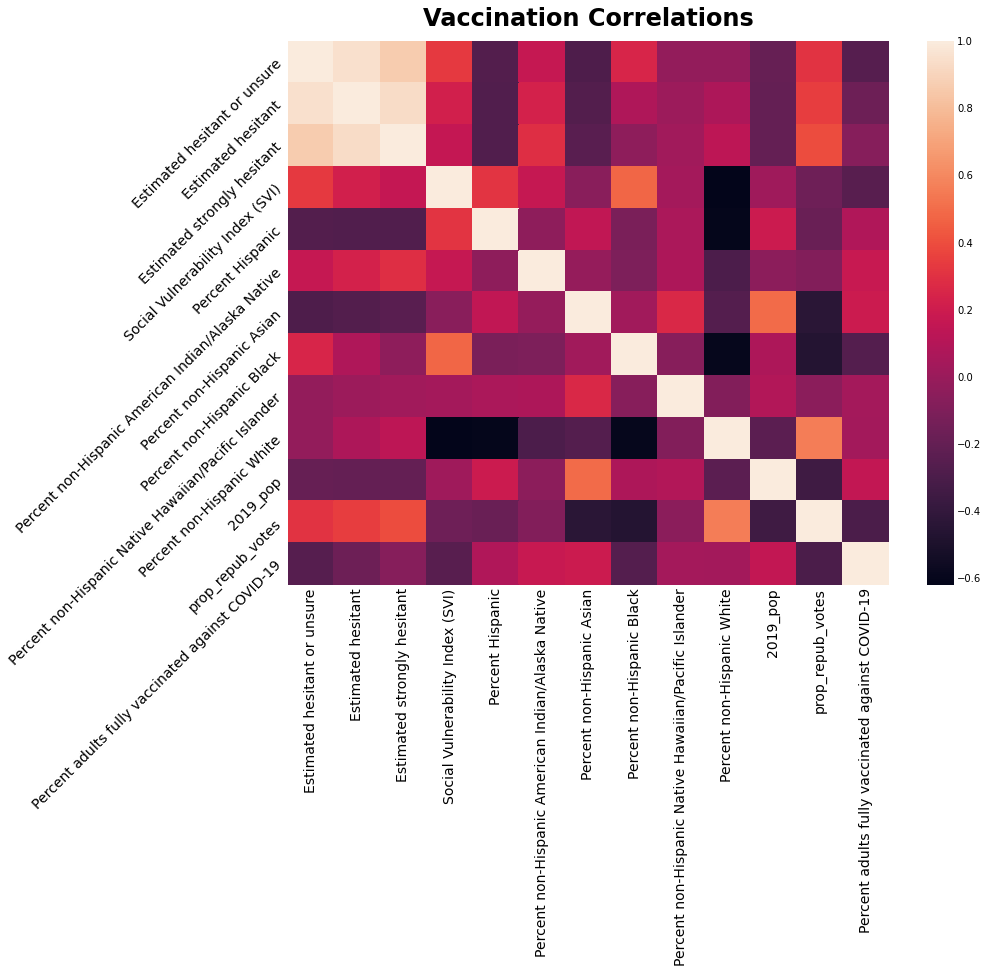

In [150]:
vacc_pop_corr = final_df[['Estimated hesitant or unsure','Estimated hesitant','Estimated strongly hesitant','Social Vulnerability Index (SVI)','Percent Hispanic','Percent non-Hispanic American Indian/Alaska Native','Percent non-Hispanic Asian','Percent non-Hispanic Black','Percent non-Hispanic Native Hawaiian/Pacific Islander','Percent non-Hispanic White','2019_pop','prop_repub_votes','Percent adults fully vaccinated against COVID-19']].corr()

#Plot the correlations
fig, ax = plt.subplots(figsize=(12,10))
att_heatmap = sns.heatmap(vacc_pop_corr)
plt.title("Vaccination Correlations", fontsize=24, fontweight=750, pad=15)
plt.yticks(rotation = 45, fontsize = 14)
plt.xticks(fontsize = 14)


plt.show()

In [151]:
vacc_pop_corr

,Estimated hesitant or unsure,Estimated hesitant,Estimated strongly hesitant,Social Vulnerability Index (SVI),Percent Hispanic,Percent non-Hispanic American Indian/Alaska Native,Percent non-Hispanic Asian,Percent non-Hispanic Black,Percent non-Hispanic Native Hawaiian/Pacific Islander,Percent non-Hispanic White,2019_pop,prop_repub_votes,Percent adults fully vaccinated against COVID-19
Estimated hesitant or unsure,1.000000,0.951288,0.866506,0.329898,-0.271600,0.170088,-0.285261,0.250760,-0.022284,-0.021611,-0.193826,0.306081,-0.258420
Estimated hesitant,0.951288,1.000000,0.934766,0.216502,-0.275046,0.229533,-0.267933,0.082347,0.007061,0.072157,-0.197222,0.344144,-0.169796
Estimated strongly hesitant,0.866506,0.934766,1.000000,0.162354,-0.275926,0.286155,-0.240616,-0.039229,0.028992,0.133167,-0.199768,0.392989,-0.072740
Social Vulnerability Index (SVI),0.329898,0.216502,0.162354,1.000000,0.313475,0.168307,-0.059360,0.475807,0.041437,-0.619811,0.024759,-0.163891,-0.250535
Percent Hispanic,-0.271600,-0.275046,-0.275926,0.313475,1.000000,-0.041919,0.151544,-0.115427,0.069544,-0.603825,0.194971,-0.180655,0.087673
Percent non-Hispanic American Indian/Alaska Native,0.170088,0.229533,0.286155,0.168307,-0.041919,1.000000,-0.016778,-0.102394,0.073598,-0.296052,-0.048401,-0.087159,0.175002
Percent non-Hispanic Asian,-0.285261,-0.267933,-0.240616,-0.059360,0.151544,-0.016778,1.000000,0.027383,0.261394,-0.264646,0.494700,-0.436405,0.191754
Percent non-Hispanic Black,0.250760,0.082347,-0.039229,0.475807,-0.115427,-0.102394,0.027383,1.000000,-0.066881,-0.597386,0.073375,-0.467385,-0.264724
Percent non-Hispanic Native Hawaiian/Pacific Islander,-0.022284,0.007061,0.028992,0.041437,0.069544,0.073598,0.261394,-0.066881,1.000000,-0.087332,0.090767,-0.056419,0.038294
Percent non-Hispanic White,-0.021611,0.072157,0.133167,-0.619811,-0.603825,-0.296052,-0.264646,-0.597386,-0.087332,1.000000,-0.239753,0.558835,0.034180


## Correlation Takeaways
The only variable with a greater than 0.3 positive or negative correlation to Percent Adults Fully Vacinated is the the Proportion of Republican Voters which eaxctly meets the 0.3 threshhold in the negative direction at -.30. <br><br>

The negative correlation between the ratio of Republican voters and vaccination rates also confirms political narratives that Republicans are hesitent about the nessececity/safety of the vaccine. In fact if we take a look at the correlation between the vaccine hesitency variables and the political leaning, we see that the variable most strongly correlated to vaccine hesitency by far is political affiliation. It's also important to note that as the hesitency becomes stronger, it becomes more strongly correlated to politcal leaning. This implies that counties that voted more Republican in 2016, express more strong hesitency about the vaccine, which may have actualized in lower vaccination rates. However it's important to remember that these are very complex issues with far more at play than these simple demographic statistics can reveal. <br><br>
The other correlation to mention is the correlation between the Social Vulnerability Index (SVI) and vaccination rate. We also see that the SVI variable is negatively correlated with Percent non-Hispanic White (-0.62), so SVI roughly correlates with the percent minority population in a county. SVI has a correlation with vaccination rate of -0.25. However, unlike political leaning the only correlation between SVI and any the vaccine hesitency variables is with the least strong hesitency of the three (hesitent or unsure). This implies that these idividuals have some hesitency about the vaccine, but may not be getting vaccinated for another reason, perhaps cost, availability, or something else entirely. What exactly is causing socially vulnerable individuals to not be vaccinated would be a topic for further research. 

Next we'll map some of these variables to see if we can infer any variations around the country. 

## Visualizations of Vaccination and Demographic Variables

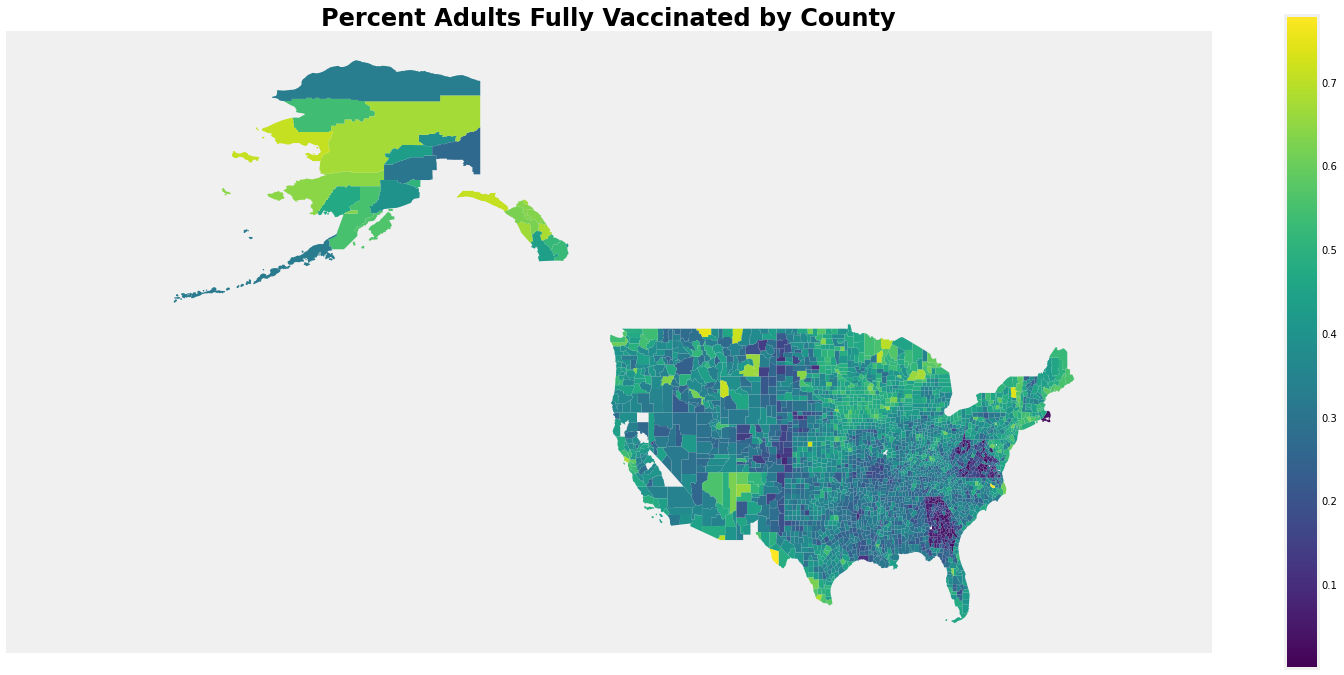

In [152]:
#Maps of these variables around the country
fig, ax = plt.subplots(1, figsize=(24,12))

ax = final_df.plot(axes=ax, column='Percent adults fully vaccinated against COVID-19', legend = True)
plt.grid(b=False, which='both')
plt.xlim([-200,-50])
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.title("Percent Adults Fully Vaccinated by County", fontsize=24, fontweight=750)

plt.show()

<b>Percent Adults Fully Vaccinated by County (above)</b><br>
Looking at the map of the United States with counties highlighted by vaccination rate we see that the most consistent higher vaccination rates appear to be in the northeast and midwest. As you move more into the Mountain West and South, however, the vaccination rate appears to start to decline. 

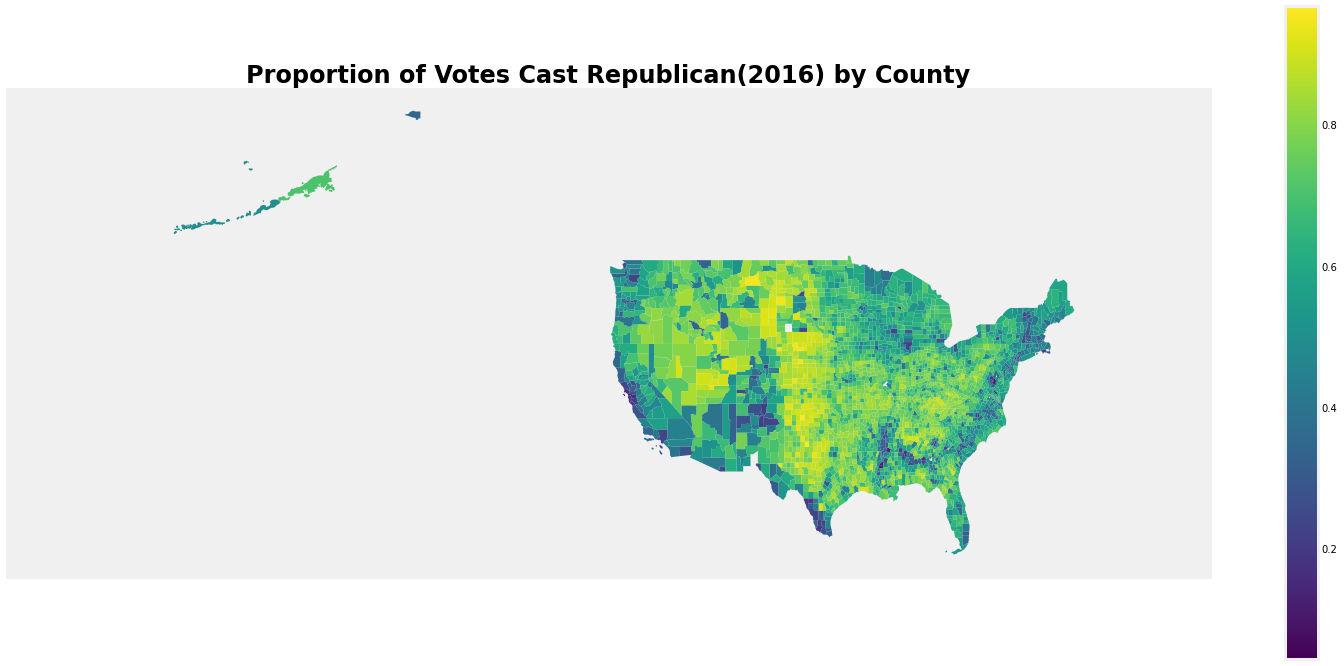

In [153]:
fig, ax = plt.subplots(1, figsize=(24,12))
ax = final_df.plot(axes=ax, column='prop_repub_votes', legend = True)
plt.grid(b=False, which='both')
plt.xlim([-200,-50])
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.title("Proportion of Votes Cast Republican(2016) by County", fontsize=24, fontweight=750)
plt.show()

<b>Proportion of Votes Cast Republican(2016) by County (above)</b><br>
Here we have the political leaning of each county with more green or yellow counties being more Republican leaning in the 2016 election and darker counties being more Democraticleaning in the 2016 election. Note that voting data was not available for much of Alaska and Hawaii was not included in all analysis as it was missing vaccination data. <br>
Here we see a line of strongly Republican counties through the middle the country and as you move your way to the coasts the counties become darker and more Democratic. If we look at this map and compare it to the vaccination map above it we see the yellow Republican line almost replicated in the inverse in the vaccination map indicating lower vaccination rates in those areas. 

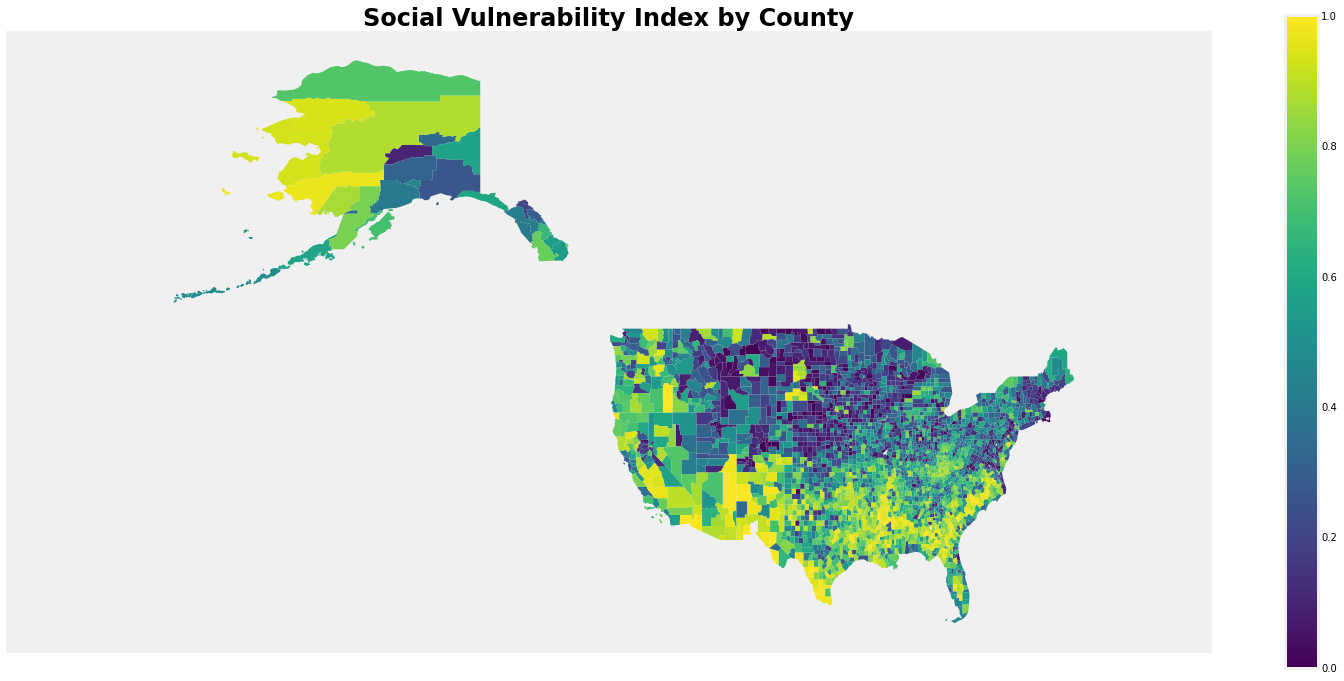

In [154]:
fig, ax = plt.subplots(1, figsize=(24,12))
ax = final_df.plot(axes=ax, column='Social Vulnerability Index (SVI)', legend = True)
plt.grid(b=False, which='both')
plt.xlim([-200,-50])
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.title("Social Vulnerability Index by County", fontsize=24, fontweight=750)

plt.show()

<b>Social Vulnerability Index by County (above)</b><br>
The above map highlights the CDC's Social Vulnerability Index by County with counties that are determined to be more vulnerable to potential negative effects caused by external stresses on human health including disease outbreaks. Lighter colors are more vulnerable and darker colors are less vulnerable. We see that many of the more vulnerable counties are located in the South and Southest and many of the less vulnerable counties are located in the Midwest and Northeast. Looking at this map next to the vaccination rate map we see that the South has a similar pattern, but in the inverse. As a we saw in the correlations, areas of higher SVI are getting vaccinated at a lower rate. This does not hold throughout the entire country, as in certain parts of the Medwest/Mountain West region SVI is low, but so are vaccination rates. 

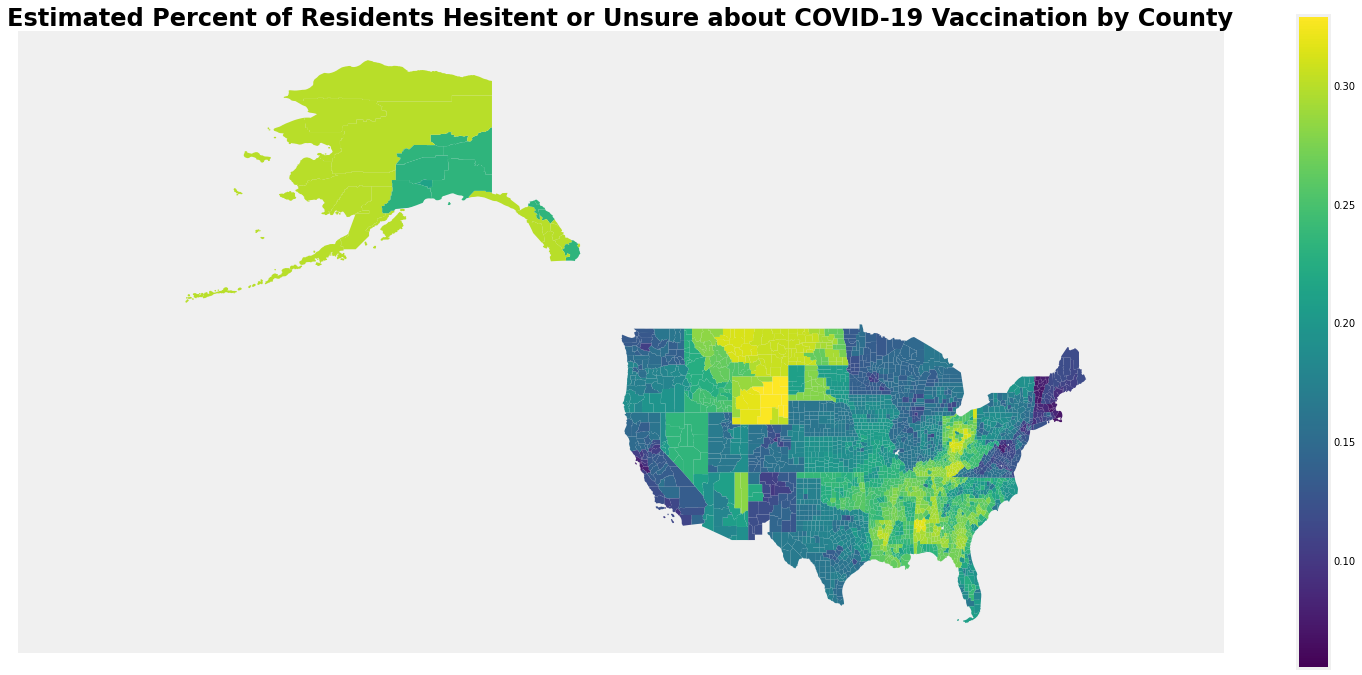

In [155]:
fig, ax = plt.subplots(1, figsize=(24,12))
ax = final_df.plot(axes=ax, column='Estimated hesitant or unsure', legend = True)
plt.grid(b=False, which='both')
plt.xlim([-200,-50])
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.title("Estimated Percent of Residents Hesitent or Unsure about COVID-19 Vaccination by County", fontsize=24, fontweight=750)

plt.show()

<b>Estimated Percent of Residents Hesitent or Unsure about COVID-19 Vaccination by County (above)</b><br>
The above map highlights the estimated percent of residents in each county that are hesitent or unsure about the COVID-19 vaccine. We see that the majority of the hesitency is in states in the Southeast and Mountain West regions. This hesitency in the Southeast is reflected in the vaccination rate map which shows vaccine rates generally being low in that area. 

## Top 500 Counties by Vaccination Rate

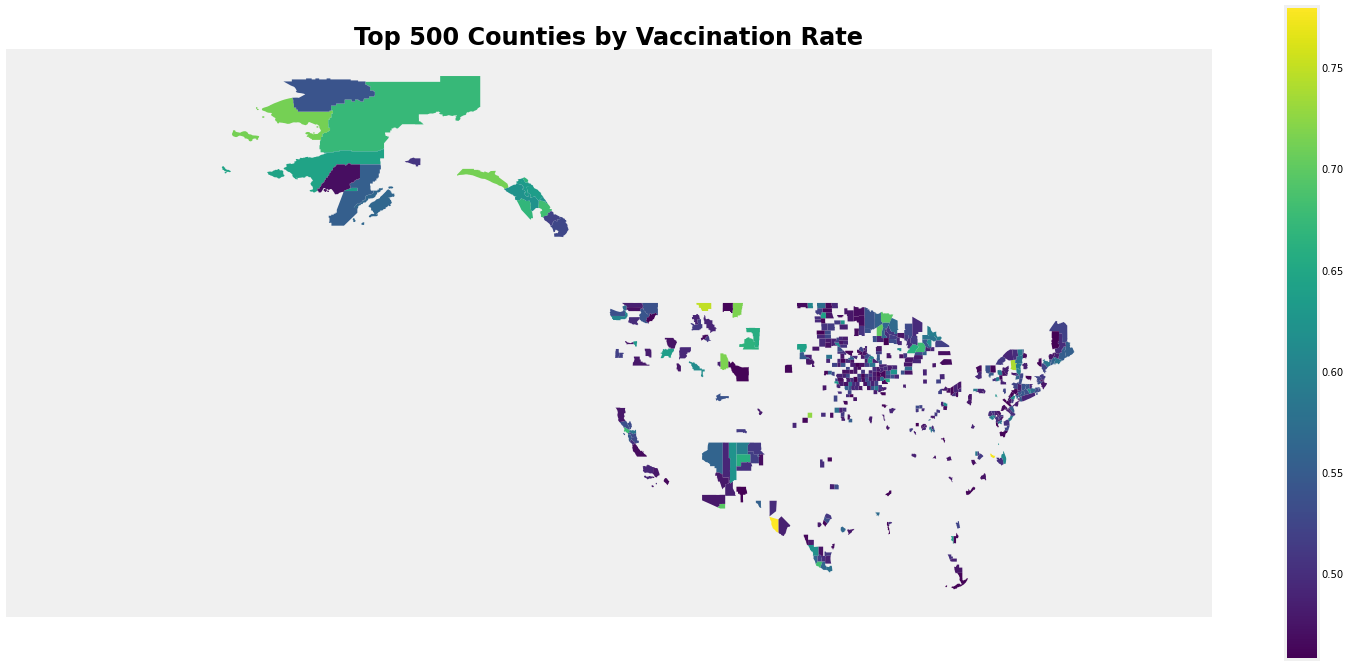

In [156]:
#Top 500 counties by vacc rate
top_500_vacc = final_df.sort_values('Percent adults fully vaccinated against COVID-19', ascending=False).head(500)
fig, ax = plt.subplots(1, figsize=(24,12))
ax = top_500_vacc.plot(axes=ax, column='Percent adults fully vaccinated against COVID-19', legend = True)
plt.grid(b=False, which='both')
plt.xlim([-200,-50])
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.title("Top 500 Counties by Vaccination Rate", fontsize=24, fontweight=750)

plt.show()

<b>Top 500 Counties by Vaccination Rate (above)</b><br>
In this final map we see the rough shape of the United States formed by the top 500 counties by vaccination rate. Our general observation that the Southeast is lower in vaccination rate continues to be supported in this view as there are few counties in that part of the country with a top vaccination rate. We see large clusters of counties in the Midwest and Northeast as well as generally around the perimeter of the country. 

### Regression Modeling

In [157]:
# remove all null values prior to modeling
regression_df = final_df.dropna()
regression_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3090 entries, 0 to 3134
Data columns (total 22 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   FIPS Code                                              3090 non-null   int64   
 1   County_Name                                            3090 non-null   object  
 2   State                                                  3090 non-null   object  
 3   Estimated hesitant                                     3090 non-null   float64 
 4   Estimated hesitant or unsure                           3090 non-null   float64 
 5   Estimated strongly hesitant                            3090 non-null   float64 
 6   Social Vulnerability Index (SVI)                       3090 non-null   float64 
 7   SVI Category                                           3090 non-null   object  
 8   CVAC level of concern for vacc

## Relationship between Political Voting and Vaccination Rate

In [158]:
rep_votes = regression_df['prop_repub_votes']
y = regression_df['Percent adults fully vaccinated against COVID-19']
x = sm.add_constant(rep_votes)

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                           
============================================================================================================
Dep. Variable:     Percent adults fully vaccinated against COVID-19   R-squared:                       0.092
Model:                                                          OLS   Adj. R-squared:                  0.092
Method:                                               Least Squares   F-statistic:                     312.4
Date:                                              Thu, 19 Aug 2021   Prob (F-statistic):           1.11e-66
Time:                                                      14:47:32   Log-Likelihood:                 2333.0
No. Observations:                                              3090   AIC:                            -4662.
Df Residuals:                                                  3088   BIC:                            -4650.
Df Model:                                                         1                                         
Covariance Type:                                          nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4960      0.009     56.679      0.000       0.479       0.513
prop_repub_votes    -0.2252      0.013    -17.676      0.000      -0.250      -0.200
==============================================================================
Omnibus:                      314.374   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              506.215
Skew:                          -0.730   Prob(JB):                    1.19e-110
Kurtosis:                       4.341   Cond. No.                         9.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='prop_repub_votes', ylabel='Percent adults fully vaccinated against COVID-19'>

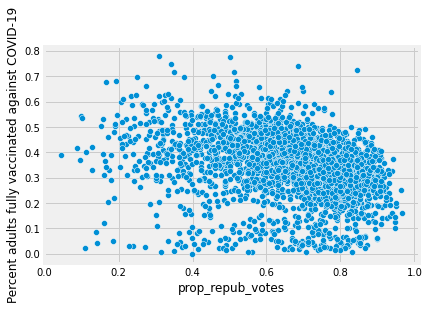

In [159]:
sns.scatterplot(rep_votes, y)

## Relationship between SVI and Vaccination Rate

In [160]:
social_vul = regression_df['Social Vulnerability Index (SVI)']
y = regression_df['Percent adults fully vaccinated against COVID-19']
x = sm.add_constant(social_vul)

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                           
============================================================================================================
Dep. Variable:     Percent adults fully vaccinated against COVID-19   R-squared:                       0.067
Model:                                                          OLS   Adj. R-squared:                  0.067
Method:                                               Least Squares   F-statistic:                     223.2
Date:                                              Thu, 19 Aug 2021   Prob (F-statistic):           8.68e-49
Time:                                                      14:47:32   Log-Likelihood:                 2291.9
No. Observations:                                              3090   AIC:                            -4580.
Df Residuals:                                                  3088   BIC:                            -4568.
Df Model:                                                         1                                         
Covariance Type:                                          nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.3991      0.004     96.415      0.000       0.391       0.407
Social Vulnerability Index (SVI)    -0.1073      0.007    -14.941      0.000      -0.121      -0.093
==============================================================================
Omnibus:                      144.533   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.999
Skew:                          -0.402   Prob(JB):                     1.88e-50
Kurtosis:                       4.064   Cond. No.                         4.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Relationship between SVI and Political Voting

In [161]:
rep_votes = regression_df['prop_repub_votes']
y = regression_df['Social Vulnerability Index (SVI)']
x = sm.add_constant(rep_votes)

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Social Vulnerability Index (SVI)   R-squared:                       0.026
Model:                                          OLS   Adj. R-squared:                  0.026
Method:                               Least Squares   F-statistic:                     84.03
Date:                              Thu, 19 Aug 2021   Prob (F-statistic):           8.64e-20
Time:                                      14:47:32   Log-Likelihood:                -505.22
No. Observations:                              3090   AIC:                             1014.
Df Residuals:                                  3088   BIC:                             1027.
Df Model:                                         1                                         
Covariance Type:                          nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6943      0.022     31.667      0.000       0.651       0.737
prop_repub_votes    -0.2926      0.032     -9.167      0.000      -0.355      -0.230
==============================================================================
Omnibus:                     2942.267   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.514
Skew:                          -0.054   Prob(JB):                     2.59e-42
Kurtosis:                       1.785   Cond. No.                         9.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Where can we Target Vaccine Information/Outreach?
This analysis confirms that voting Republican is correlated with lower vaccination rates. However, I don't think using people's politcal views as a reason to educate them about the vaccine would be particularily effective as our political climate is fraught with turmoil as it is. However, counties with a higher Social Vulnerability Index also tend to be vaccinated at a lower rate and be hesitent about the vaccine. If we could identify counties that are above average in SVI, but below average in vaccine rate and below 50 percent of republican voters we could identify counties worth targeting with outreach, without seeing as much political resistence.  

In [162]:
svi_avg = final_df['Social Vulnerability Index (SVI)'].mean()
vacc_avg = final_df['Percent adults fully vaccinated against COVID-19'].mean()
republican_vote_avg = 0.5
outreach_counties = final_df[(final_df['Social Vulnerability Index (SVI)'] > svi_avg)
                             & (final_df['Percent adults fully vaccinated against COVID-19'] < vacc_avg)
                             & (final_df['prop_repub_votes'] < republican_vote_avg)]
len(outreach_counties.index)

116

In [163]:
view_bounds = outreach_counties.geometry.total_bounds
xmin, ymin, xmax, ymax = view_bounds
view_bounds

array([-121.585078,   28.640566,  -74.851794,   47.260659])

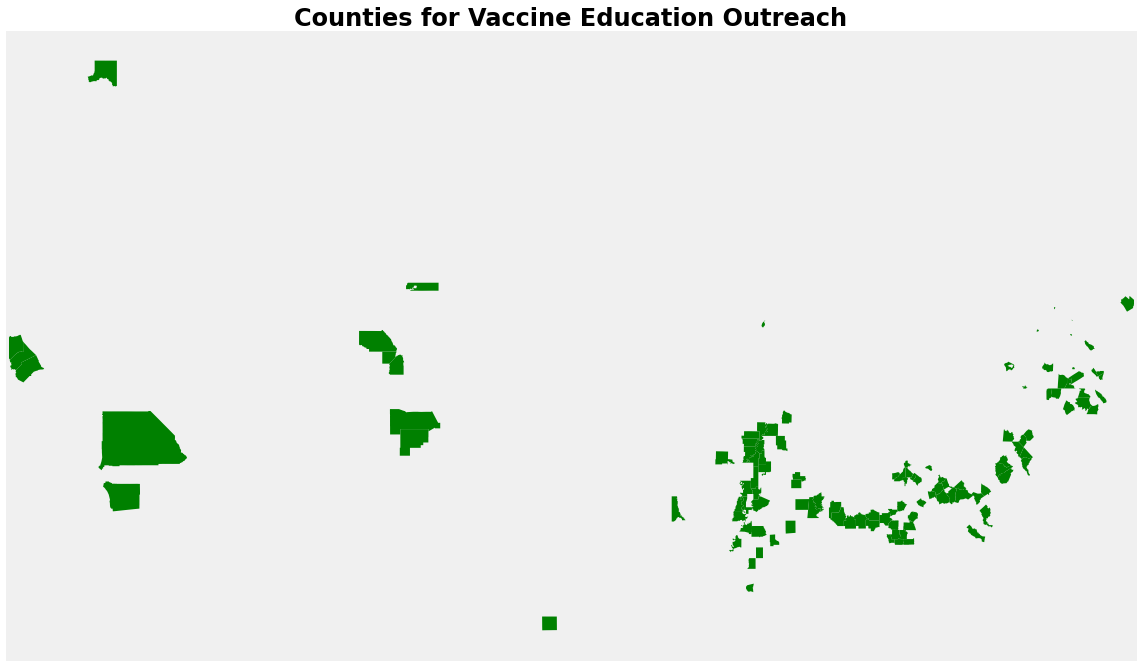

In [164]:
fig, ax = plt.subplots(1, figsize=(18,12))
outreach_counties.plot(axes=ax, color = 'g')
plt.grid(b=False, which='both')
ax.set_xlim(left=xmin, right=xmax)

ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.title("Counties for Vaccine Education Outreach", fontsize=24, fontweight=750)

plt.show()

In [165]:
#population of these outreach counties
print('Total population of these counties is:', outreach_counties['2019_pop'].sum())

Total population of these counties is: 15673167.0


In [166]:
# Group and count by state to see which state has the most counties that fit our criteria
state_group = outreach_counties.groupby('State')['State Code'].count()
state_count = state_group.reset_index().sort_values('State Code', ascending=False)
state_count = state_count.rename(mapper={'State Code': 'Count'}, axis='columns')

state_count

,State,Count
4,GEORGIA,27
6,MISSISSIPPI,19
14,VIRGINIA,15
10,NORTH CAROLINA,10
0,ALABAMA,9
11,SOUTH CAROLINA,9
1,ARKANSAS,5
2,CALIFORNIA,5
5,LOUISIANA,5
3,COLORADO,4


## Conclusion and Areas for Further Research 
Ultimately, vaccinating a huge population against a new disease, the understanding of which consinutes to evolve, is a very complex issue and it would be irresponsible to make any difinitive claims based on this straight forward exploratory data analysis. However, we can identify some basic trends and areas for more in depth research.<br><br>
Of the data we looked at, the strongest connection was between political leaning and vaccination rate, with Republican areas showing lower vaccination rates as of May 23, 2021. When placed on a map of the United States it appears this is most strongly concentrated in the Southeast and Central parts of the United States. It appears as though this political leaning is connected to hesitency when it comes to the vaccine, which may be leading to lower vaccination rates.<br>
Interestly, we see a similar trend in areas of the Southeast with high Social Vulnerability and low vaccination rates. However, SVI and Republican voting are negatively correlated, so while these may look aligned when zoomed out, the individual counties must be divided. 

### Regression Analysis
We see that percent of Republican voters in a county is negatively correlated with vaccination rate to a statistically signifcant degree. For an increase in Republican voting of 10% we would expect to see a 2.2% decrease in vaccination rate. 

I then checked the relationship between SVI and vaccination rate and saw that a 10% increase in SVI would predict a 1% decrease in vaccination rate to a statistically significant degree. Since this is the same direction of movement as the policatal leaning connection I then checked to see the direction of the connection between the two. 

I found that SVI and percent of Republican voters in a county were negativelt correlated to a significant degree indicating that that lower vaccination rates in areas with higher SVI was not due to an increase in republican voters in that area and other factors were at play.

### Outreach reccommendation

This leads me to believe that there must be counties that did not vote Republican, have a high SVI, and a low vaccination rate. Because vaccination is a highly political issue and engaging people on the Republican end of the politcal spectrum may be difficult. I identified counties with a low vaccination rate, higher than average SVI rating, and less than 50% of votes cast Republican. In theory these counties would make prime candidates for educational outreach for vaccination. 

<b>Areas of Further research</b><br>
1. What factors lead to people of high social vulnerability to not get vaccinated? Is it access, cost, importance, or some other factor. Perhaps comparing smaller subgroups of high SVI areas, some that are getting vaccinated and others that are not could provide some insight.
2. Look carefully at the Southeast part of the United States to determine areas that are not getting vaccinated at a high rate and investigate why. 
3. Incorporate county population into the maps to give context to the number of people in each county as they are not all weighted equally in reality. 